Student Details

Name: Tom Keane

ID: 20214537

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler,  RobustScaler,FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
#from scipy import interp
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats

## EDA - Exploratory Data Analysis

In [2]:
df = pd.read_csv("./seeds.csv")
df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [3]:
df.tail()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3
209,12.30,13.34,0.8684,5.243,2.974,5.637,5.063,3


In [4]:
df['type'].value_counts()

1    70
2    70
3    70
Name: type, dtype: int64

In [5]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

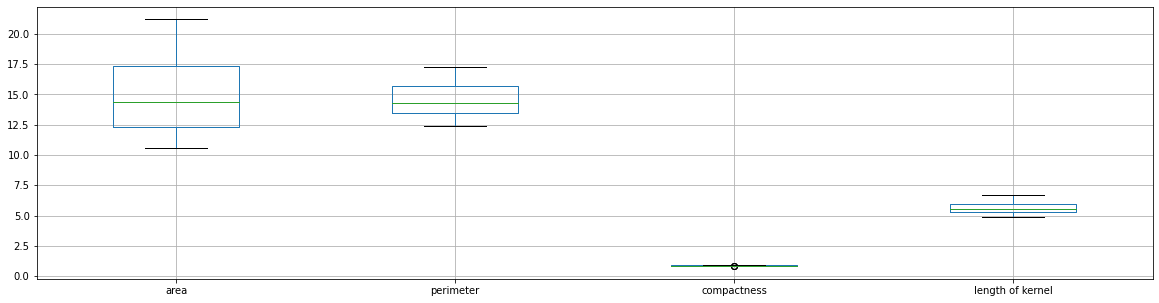

In [6]:
df.loc[:,'area':'length of kernel'].boxplot(figsize=(20,5))
plt.show()

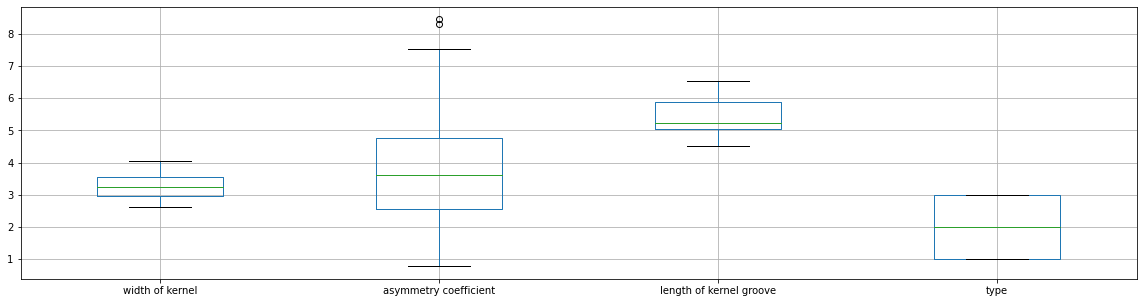

In [7]:
df.loc[:,'width of kernel':].boxplot(figsize=(20,5))
plt.show()

In [8]:
print('ouliers')
display(df[(np.abs(stats.zscore(df)) >= 3).all(axis=1)].head())

ouliers


,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type


No clear columns with outliers

In [9]:
round(df.groupby(['type']).mean(),2)

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove
type,,,,,,,
1,14.33,14.29,0.88,5.51,3.24,2.67,5.09
2,18.33,16.14,0.88,6.15,3.68,3.64,6.02
3,11.87,13.25,0.85,5.23,2.85,4.79,5.12


I will choose task_2 as my focus feature.

## Data Preparation



In [10]:
df = pd.get_dummies(df, columns=['type'], 
                        dummy_na=False, 
                        drop_first=False)
display(df.head())

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type_1,type_2,type_3
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,0,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,0,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,0,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,0,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,0,0


In [11]:
focus = 'type_2'
df = df.drop(['type_1', 'type_3'], axis=1)

# store a list with the names of all predictors
names_all = [c for c in df if c not in [focus]]
# names_outliers=list(set([]))
names_no_outliers = list(set(names_all))

In [12]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [13]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type_1,type_2,type_3
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,0,0
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,0,0
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,0,0
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,0,0
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,0,0


In [14]:
preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        # ("outlier_columns", make_pipeline(
        #     ColumnSelector(columns=names_outliers),
        #     FunctionTransformer(np.log, validate=True),
        #     RobustScaler()
        # )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [15]:
y = df[focus]
X = df.drop(focus, axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Grid Search for Best Parameters of Classifiers

In [16]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of svn.SVC and their possible values

param_grid = {
    'svm__C': [0.1, 1, 10, 100],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train) #trainign happens here! SVM is trained 240 times
#Julia

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.994:
Best parameters:  {'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'linear'}


In [17]:
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

# prepare a prameter grid
# note that __ can be used to specify the name of a parameter for a specific element in a pipeline
# note also that this is not an exhaustive list of the parameters of RandomForestClassifier and their possible values
param_grid = {
    'rf__n_estimators' : [10,20,30],
    'rf__max_depth': [2, 4, 6, 8]
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.988:
Best parameters:  {'rf__max_depth': 2, 'rf__n_estimators': 10}


In [18]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [19]:
# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the classifier learns to predict probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:,1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [20]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)

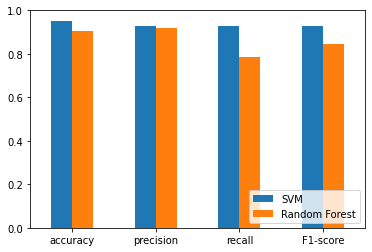

In [21]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

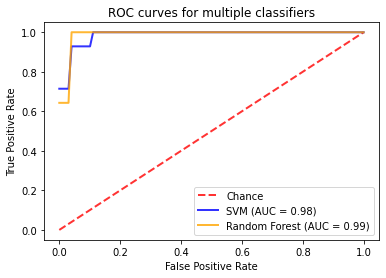

In [22]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

The Best SVM model beats the best Random Forest for accuracy, precision, recall and F1-score, making it the best classifier for identifying type_2 seeds overall.

Both models have excellent Areas Under Curve, ilustrating their fine performance. Counterinutuitively, the Random Forest often has more AUC, than the SVM.

## Train a Final Model

In [23]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)

In [24]:
filename = 'CS5062_task3_final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))

# TASK 3

For this task I will be using the GradientBoostingClassifier in conjunction with the a GridSearch Classifier. 

## [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
 From the documentation:
 
        GB builds an additive model in a forward stage-wise fashion; 
    it allows for the optimization of arbitrary differentiable loss functions.
    In each stage n_classes_ regression trees are fit on the negative gradient of the 
    binomial or multinomial deviance loss function. Binary classification is a special case where
    only a single regression tree is induced.

Our use case is binary classification (type_2 or not type_2), so therefore we will only have a single regression tree in our Gradient Boosting Classifier.

### What is Boosting.

[Here](https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab) is the most concise explanation I could find, which uses the Adaboost algorithm as an example.

     Boosting is a method of converting weak learners into strong learners.
    In boosting, each new tree is a fit on a modified version of the original data set.

    The AdaBoost Algorithm begins by training a decision tree in which each observation is 
    assigned an equal weight. After evaluating the first tree, we increase the weights of those 
    observations that are difficult to classify and lower the weights for those that are easy to 
    classify. The second tree is therefore grown on this weighted data. Here, the idea is to improve
     upon the predictions of the first tree. Our new model is therefore Tree 1 + Tree 2. We then 
    compute the classification error from this new 2-tree ensemble model and grow a third tree to 
    predict the revised residuals. We repeat this process for a specified number of iterations. 
    Subsequent trees help us to classify observations that are not well classified by the previous 
    trees. Predictions of the final ensemble model is therefore the weighted sum of the predictions 
    made by the previous tree models.
    
Gradient Boosting trains many models in a gradual, additive and sequential manner,
and does so by using gradients in the loss function, to identify the shortcomings
of weak learners (eg. decision trees).


## [Grid Search Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearch#sklearn.model_selection.GridSearchCV)

Simply put, this implements a “fit” and a “score” by cross validating with another classifier, (GradientBoost in our case).

In [63]:
from sklearn.ensemble import GradientBoostingClassifier
grd = GradientBoostingClassifier(n_estimators=1, learning_rate=1.0,
     max_depth=1, random_state=0).fit(X_train, y_train)

pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('boost', GradientBoostingClassifier())])
param_grid = {
    # 'boost__n_estimators' : [3],
    # 'boost__max_depth': [3, 6, 9, 12, 24]
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print(F"best score = %0.3f:" % search.best_score_)

# store the best params and best model for later use
Boost_best_params = search.best_params_
Boost_best_model = search.best_estimator_

# The gradient boosted model by itself
y_pred_grd = grd.predict_proba(X_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)

grd_accuracy, grd_precision, grd_recall, grd_f1_score, grd_tpr, grd_auc = evaluate_model(X_test, y_test, Boost_best_model)

best score = 0.988:


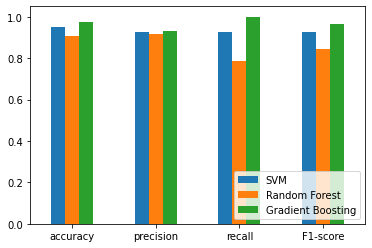

In [64]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
grd_metrics = np.array([grd_accuracy, grd_precision, grd_recall, grd_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,
                           'Gradient Boosting': grd_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

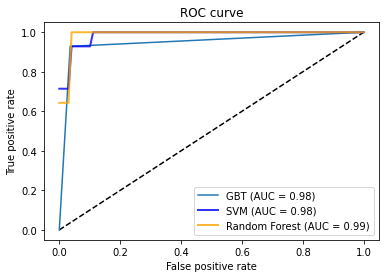

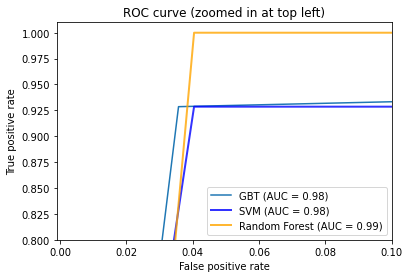

In [65]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grd, tpr_grd, label=f'GBT (AUC = {round(grd_auc, 2)})')
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(-0.001, 0.1)
plt.ylim(0.8, 1.01)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_grd, tpr_grd, label=f'GBT (AUC = {round(grd_auc, 2)})')
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()




## Conclusions/ Notes

The Gradient boosting algorithm usually outperforms the Random Forest and SVM, however random forest seems to perform best at low false positive rates.

having played with the parameterers, it seems that boost__n_estimators & boost__max_depth as grid search parameters have no effect on performance. it seems that not much depth is needed for the Gradient boosting algorithm to perform well here. Similarly, n_estimators has little effect on performance as well, there are no notable changes to results when n_estimators is at 1 or 100.